# SIFT-RANSAC image registration of x-ray halves

In [12]:
import numpy as np
import cv2
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os 

In [18]:
xray_jpgs = sorted(glob('/home/frank/Work/Werknummers/2024-811_Falnama/data/01_Xray-images/03_xray-jpgs/*.jpg'))
bot_jpg, top_jpg = xray_jpgs[0:2]
top_jpg, bot_jpg

('/home/frank/Work/Werknummers/2024-811_Falnama/data/01_Xray-images/03_xray-jpgs/71803-01_top_Falnama_grenz_1-2_edited.jpg',
 '/home/frank/Work/Werknummers/2024-811_Falnama/data/01_Xray-images/03_xray-jpgs/71803-01_bottom_Falnama_grenz_2-2_edited.jpg')

In [19]:
both = sift_ransac_xray_stitch(top_jpg, bot_jpg)

In [21]:
%matplotlib widget

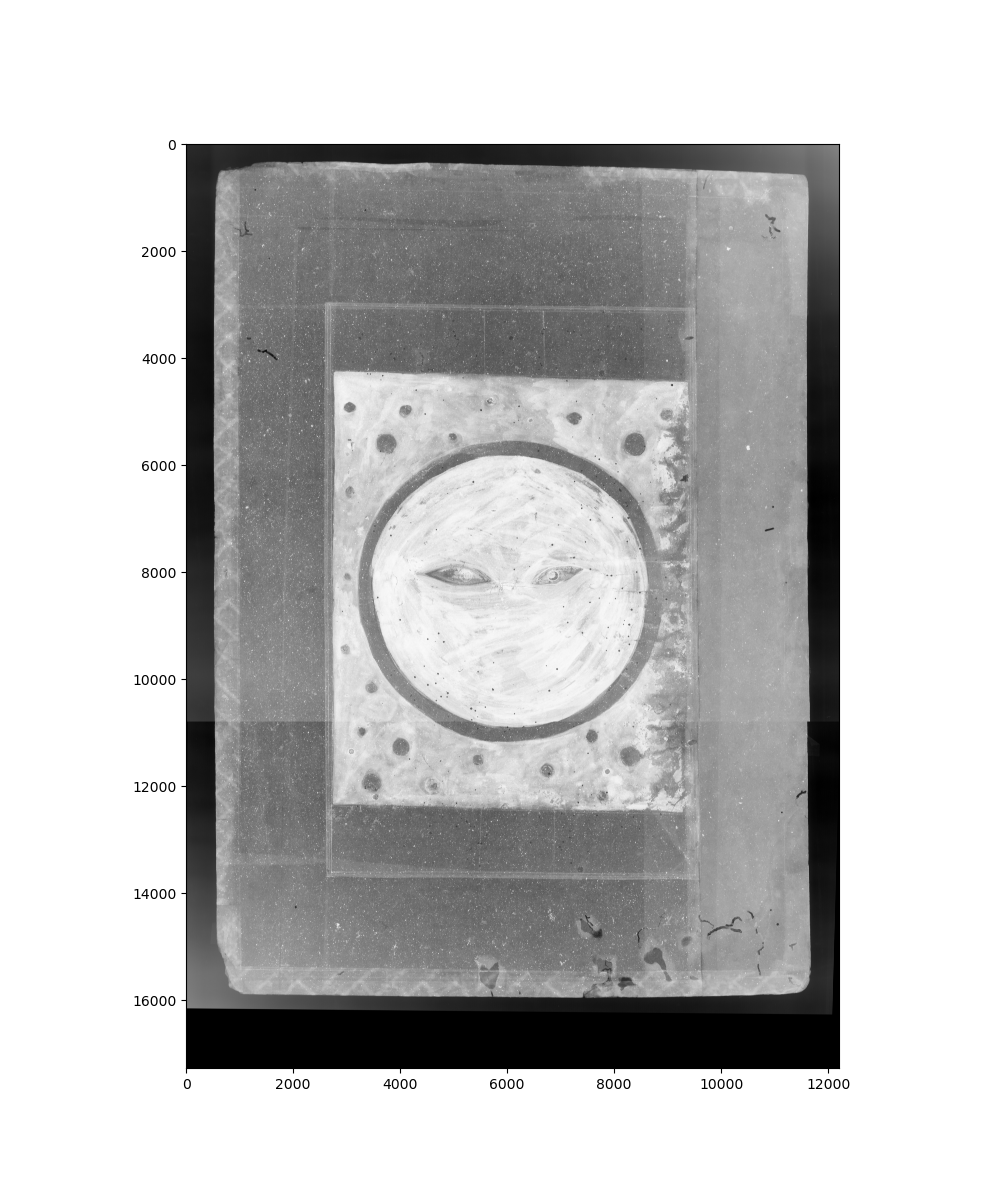

In [22]:
fig, ax = plt.subplots(figsize=[10, 12])
ax.imshow(both)

In [4]:
def sift_ransac_xray_stitch(im1_path, im2_path, scale_x=1, scale_y=1.6): 
    '''Ad hoc code for stitching upper and lower halves of x-ray images. 
    
    `im1_path` should be the upper half and is the destination image, while  
    im2_path is source image and will be warped. '''
    
    # Load the images
    im1 = cv2.imread(im1_path)
    im2 = cv2.imread(im2_path)
    
    # Convert images to grayscale for keypoint detection
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector: scale-invariant feature transform (you can use ORB if SIFT is not available)
    sift = cv2.SIFT_create()
    
    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(im1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2_gray, None)
    
    # Use BFMatcher to find the best matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort the matches based on distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract the matched keypoints
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Find homography matrix and mask 
    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    is_ransac = mask.flatten().astype(bool)
    
    # Warp the image2 to align it with the (extended) image1
    height, width, _ = im1.shape
    im2_aligned = cv2.warpPerspective(im2, H, (int(scale_x*width), int(1.6*height)))
    
    # Stitch destination image im1 
    h, w, d = im1.shape 
    im2_aligned[0:h, 0:w] = im1 

    # Save 

    return im2_aligned 

In [126]:
points1.shape

(658, 1, 2)

Ok, let's plot the points on both images. 

In [127]:
%matplotlib widget

In [128]:
x1, y1 = points1.reshape([-1, 2]).T
x2, y2 = points2.reshape([-1, 2]).T

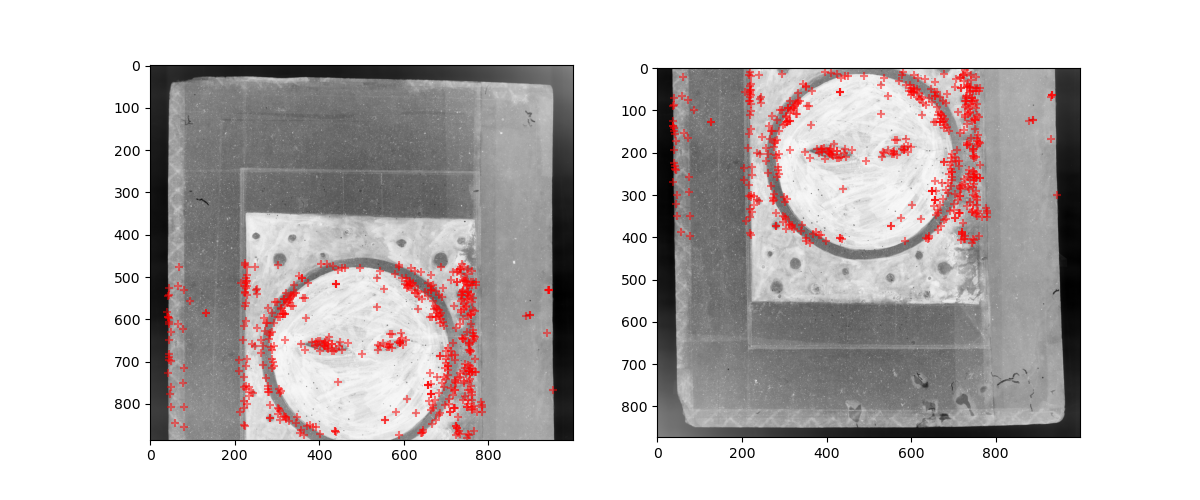

In [129]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=[12, 5], squeeze=True)
ax1.imshow(im1)
ax2.imshow(im2)
ax1.scatter(x1[is_ransac], y1[is_ransac], marker='+', color='r', alpha=0.5)
ax2.scatter(x2[is_ransac], y2[is_ransac], marker='+', color='r', alpha=0.5)

Ok, so far so good. The documentation of opencv provides a function that plots the matched points side-by-side: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [106]:
len(matches)

658

In [108]:
# Draw first 10 matches.
img3 = cv2.drawMatches(im1,keypoints1,im2,keypoints2, matches[:100],None) #,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

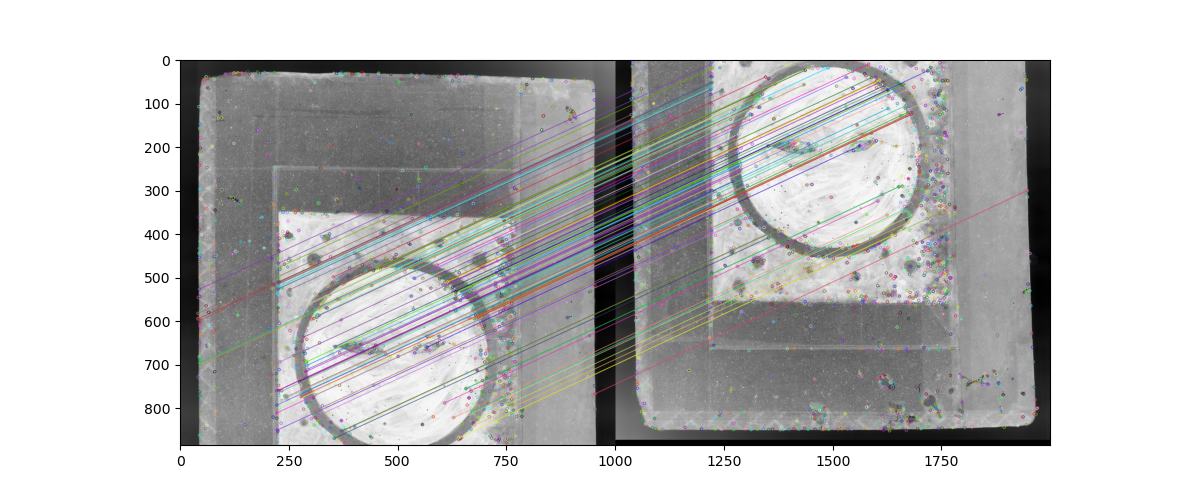

In [109]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.imshow(img3)

Next problem to solve is how to combine both image areas instead of cropping onto one or the other... 

In [119]:
min(y1[is_ransac])

466.87967

In [146]:
# Warp the image2 to align it with the image1
height, width, _ = im1.shape
im2_aligned = cv2.warpPerspective(im2, H, (width, int(1.6*height)))
h, w, d = im1.shape 
im2_aligned[0:h, 0:w] = im1

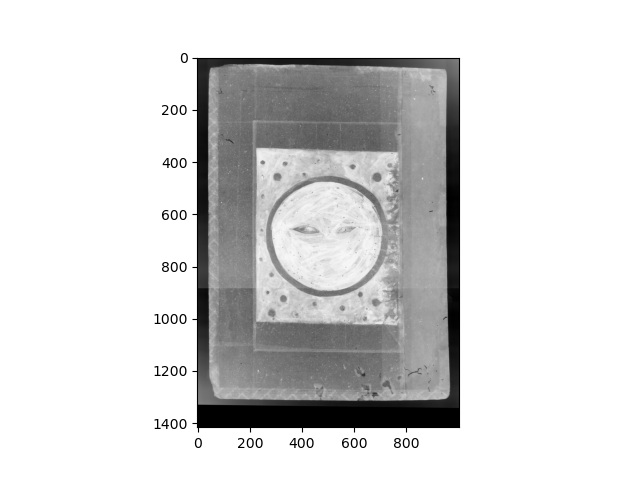

In [147]:
fig, ax = plt.subplots()
ax.imshow(im2_aligned)

Next, we need add the destination image 

In [139]:
h, w, d = im1.shape
im2_aligned[0:h, 0:w] = im1

## Gauthiers code

In [68]:
def register_im(im2_path, im1_path):
    """
    Register an image (im2) according to another image (im1). 
    
    Parameters:
    im1_path (str): the absolute path of the reference image
    im2_path (str): the absolute path of the image that should be registered
    
    Returns:
    a TIF file of the registered image.
    """
    
    # Load the images
    im1 = cv2.imread(im1_path)
    im2 = cv2.imread(im2_path)
        
    # Convert images to grayscale for keypoint detection
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector: scale-invariant feature transform (you can use ORB if SIFT is not available)
    sift = cv2.SIFT_create()
    
    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(im1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2_gray, None)
    
    # Use BFMatcher to find the best matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort the matches based on distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract the matched keypoints
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Find homography matrix
    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Warp the image2 to align it with the image1
    height, width, _ = im1.shape
    im2_aligned = cv2.warpPerspective(im2, H, (width, height))

    

    # Crop the aligned UV image to the size of the normal image
    #im2_cropped = im2_aligned[0:height, 0:width]

    # Save the registered image
    im2_path = Path(im2_path)
    new_filename = f'{im2_path.parent}/{im2_path.stem}_registered{im2_path.suffix}'
    print(f'Create registered image: {new_filename}')
    #cv2.imwrite(new_filename, im2_cropped)
    cv2.imwrite(new_filename, im2_aligned)
    
    return new_filename

Let's see if top and bottom are registered automatically. Next fix cropping. 

In [7]:
xray_jpgs = sorted(glob('../viz/xray-jpgs/*'))

In [8]:
xray_jpgs

['../viz/xray-jpgs/71803-10_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-10_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-11_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-11_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-17_bottom_Falnama_genz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-17_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-19_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-19_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-1_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-1_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-20_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-20_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-21_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-21_top_Falnama_grenz_1-2_edited.jpg',
 '../viz/xray-jpgs/71803-22_bottom_Falnama_grenz_2-2_edited.jpg',
 '../viz/xray-jpgs/71803-22_top_Fa

In [9]:
im1, im2 = xray_jpgs[0:2]

Ok, seems to work. However, rather slow and we need to adjust the cropping... Let's explore the code on a lower resolution image pair...  

In [67]:
pngs = glob('../viz/xray-jpgs-registered/*.png')
pngs

['../viz/xray-jpgs-registered/71803-1_top_Falnama_grenz_1-2_edited.jpg_small.png',
 '../viz/xray-jpgs-registered/71803-1_bottom_Falnama_grenz_2-2_edited.jpg_small.png']

let's extend the top im1 with a black lower margin.

In [ ]:
h, w, d = im1.shape
s = max([h, w]) # canvas squares size

im1_canvas = np.zeros([3*s, 3*s, d], dtype=np.uint8)
im1_canvas[s:s+h, s:s+w] = im1

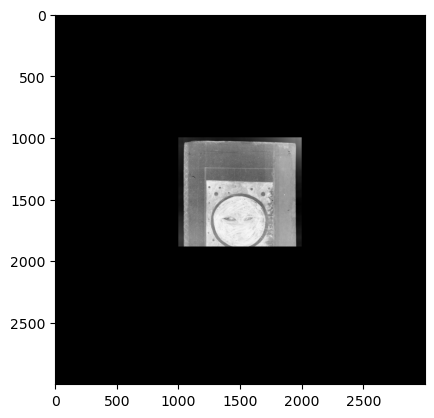

In [50]:
fig, ax = plt.subplots()
ax.imshow(im1_canvas)

In [34]:
im1

(873, 1000, 3)

In [69]:
reg_im = register_im(*pngs)

Create registered image: ../viz/xray-jpgs-registered/71803-1_top_Falnama_grenz_1-2_edited.jpg_small_registered.png


In [23]:
im1

'../viz/xray-jpgs-registered/71803-1_top_Falnama_grenz_1-2_edited.jpg_small.png'

In [24]:
im1

AttributeError: 'str' object has no attribute 'shape'